# Run a single synthesis and analyse it

In [2]:
%matplotlib inline

# Specify CUDA device
# import os
# os.environ['CUDA_VISIBLE_DEVICES'] = 'gpu'

from jax import jit, config, grad
config.update("jax_enable_x64", True)

# Check we're running on GPU
# from jax.lib import xla_bridge
# print(xla_bridge.get_backend().platform)

import time
import numpy as np
import healpy as hp
import jax.numpy as jnp
import optax
import jaxopt

from matplotlib import pyplot as plt
from importlib import reload

import scatcovjax.Sphere_lib as sphlib
import scatcovjax.Synthesis_lib as synlib
import scatcovjax.Fast_scattering_lib as scatlib
#import scatcovjax.Scattering_lib as scatlib
from s2wav.filter_factory.filters import filters_directional_vectorised

import s2fft
import s2wav

import scatcovjax.plotting as plot
plot.notebook_plot_format()

In [3]:
import jax
# Check we're running on GPU
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)

gpu


# Parameters

In [4]:
reload(scatlib)

<module 'scatcovjax.Fast_scattering_lib' from '/mesopsl3/home/lmousset/projet/scatcovJAX/scatcovjax/Fast_scattering_lib.py'>

In [114]:
sampling = "mw"
multiresolution = True
reality = True

L = 256
N = 3
J_min = 2
lam = 2.0#np.sqrt(2)

J_max = s2wav.utils.shapes.j_max(L, lam=lam)
J = J_max - J_min + 1
print(f'{J=} {J_max=}')


J=7 J_max=8


# Filters

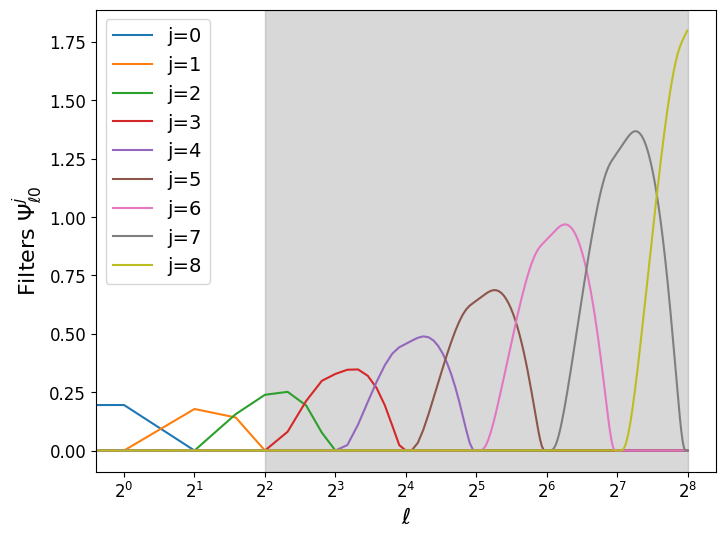

In [115]:
filters = filters_directional_vectorised(L, N, J_min, lam=lam)
plot.plot_filters(filters, real=True, m=L-1)
plt.axvspan(lam**J_min, lam**J_max, color='grey', alpha=0.3)

# Take the wavelets only, not the scaling function
filters = filters[0]  

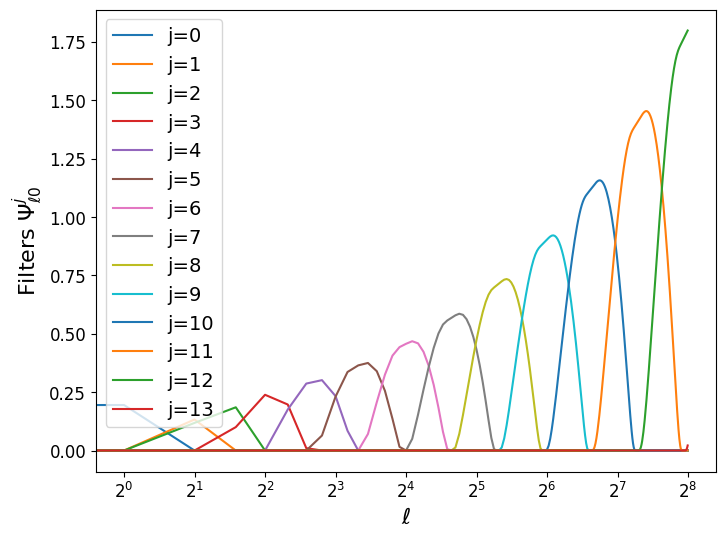

In [119]:
lam_prime = np.sqrt(2.5)
filter_lin = filters_directional_vectorised(L=L, N=N, J_min=J_min, lam=lam_prime)
plot.plot_filters(filter_lin, real=True, m=L-1)

# Take the wavelets only (not the scaling function) and select the m=0 
filter_lin = filter_lin[0][:-2, :, L-1] # Remove the last filter  

Nfilters = filter_lin.shape[0]

(12, 256)


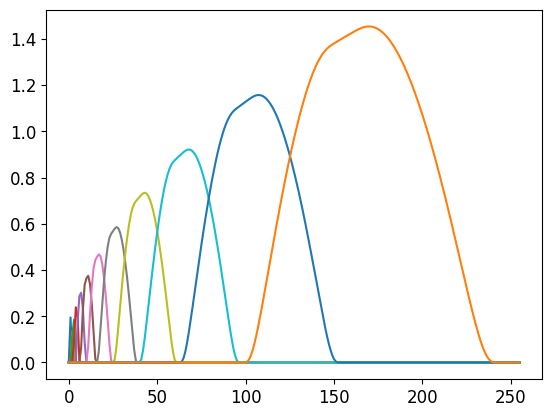

In [120]:
print(filter_lin.shape)
plt.figure()
for i in range(Nfilters):
    plt.plot(filter_lin[i, :])

# Weights and precomps

In [121]:
reload(scatlib)
weights = scatlib.quadrature(L, J_min, lam, sampling, None, multiresolution)

#precomps = s2wav.transforms.jax_wavelets.generate_wigner_precomputes(L, N, J_min, lam, sampling, None, False,
 #                                                                    reality, multiresolution)

print('\n============ Wigner precomputes ===============')
precomps = scatlib.generate_full_precompute(L=L,
                                    N=N,
                                    J_min=J_min,
                                    lam=lam,
                                    sampling=sampling,
                                    reality=reality,
                                    multiresolution=multiresolution,
                                    nside=None)




============ Wigner precomputes ===============


In [122]:
#import pickle
#file_to_store = open(f"/travail/lmousset/precomp/precomps_L{L}_N{N}.pickle", "wb")
#pickle.dump(precomps, file_to_store)
#file_to_store.close()

In [123]:
#file_to_read = open(f"/travail/lmousset/precomp/precomps_L{L}_N{N}.pickle", "rb")
#toto = pickle.load(file_to_read)
#file_to_read.close()
#print(toto)

# Target map

In [124]:
reload(sphlib)
### Sky
#repo = '/travail/lmousset/CosmoGrid/CosmoFiducial_barionified_nside512/'
#f_target, flm_target = sphlib.make_CosmoGrid_sky(L, dirmap=repo, run=0, idx_z=10, sampling=sampling, 
 #                                 nest=False, normalize=True, reality=reality)
#print('Target = LSS map')

# Lensing map from Ulagam
#mapfile = '/travail/lmousset/Ulagam/kappa_00099.fits'
#f_target, flm_target = sphlib.make_NASAsimu_sky(L, mapfile=mapfile, sapling=sampling, 
 #                                           nest=False, normalize=True, reality=reality)
    
#NASA maps
#mapfile = '/travail/lmousset/NASAsimu/tSZ_skymap_healpix_nopell_Nside4096_y_tSZrescale0p75.fits'
#f_target, flm_target = sphlib.make_NASAsimu_sky(L, mapfile=mapfile, sampling=sampling, 
                                                #nest=False, normalize=True, reality=reality)


#f_target, flm_target = sphlib.make_MW_lensing(L, normalize=True, reality=reality)
#print('Target = LSS map')

#f_target, flm_target = sphlib.make_pysm_sky(L, 'cmb', sampling=sampling, nest=False, normalize=True, reality=reality)
#print('Target = CMB map')

planet='venus'
f_target, flm_target = sphlib.make_planet(L, planet, normalize=True, reality=reality)
print('Target = Planet map')

(256, 511)
Mean and STD: -0.000 and 1.000
Target = Planet map


## Plot the map

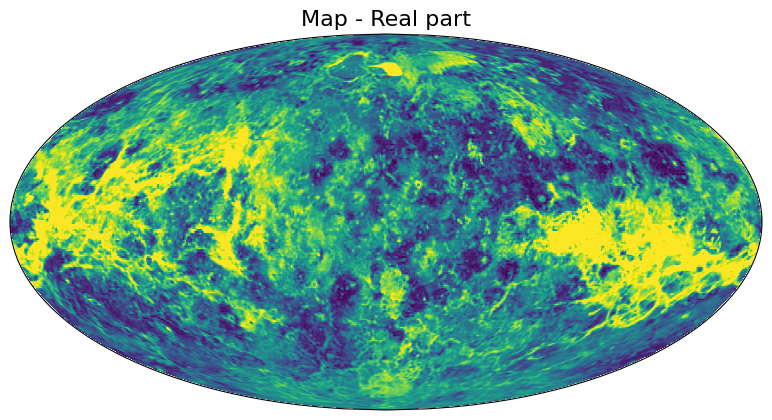

In [125]:
# Plot the map
mx, mn = np.nanmax(np.real(f_target)), np.nanmin(np.real(f_target))
fig = plot.plot_map_MW_Mollweide(np.real(f_target), figsize=(8, 6), vmin=-2, vmax=2, 
                                 pole_latitude=90, pole_longitude=180)

## Target coefficients

In [126]:
reload(scatlib)
### Power spectrum of the target
ps_target = sphlib.compute_ps(flm_target, reality=True)

### P00 for normalisation
tP00_norm = scatlib.get_P00only(flm_target, L, N, J_min, lam, sampling, None,
                                reality, multiresolution, for_synthesis=False, normalisation=None,
                                filters=filters, quads=weights, precomps=precomps)  # [J][Norient]

### Scat coeffs S1, P00, C01, C11
# P00 is one because of the normalisation
tcoeffs = scatlib.scat_cov_dir(flm_target, L, N, J_min, lam, sampling, None,
                       reality, multiresolution, for_synthesis=True, normalisation=tP00_norm,
                       filters=filters, quads=weights, precomps=precomps)

tmean, tvar, tS1, tP00, tC01, tC11 = tcoeffs  # 1D arrays

[4.20594425e-05 1.11690635e-04 1.60746291e-04 2.63689524e-04
 2.59971361e-04 3.55502820e-04 5.07637674e-04 8.56099469e-04
 1.07883266e-03 1.78024508e-03 2.65833886e-03 3.80067689e-03]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


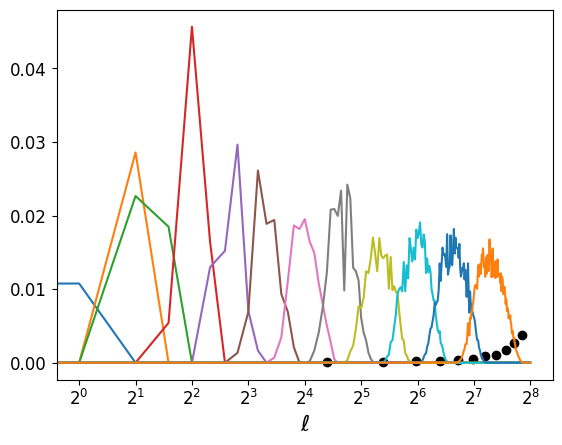

In [127]:
# P00prime used for normalisation
tP00prime_ell, tP00prime_norm = scatlib.get_P00prime(flm_target, filter_lin, normalisation=None)
print(tP00prime_norm)

plt.figure()
for j in range(Nfilters):
    plt.plot(tP00prime_ell[j, :])
    plt.plot(L//Nfilters * j, tP00prime_norm[j], 'ko')
plt.xscale('log', base=2)
plt.xlabel(r'$\ell$')

# By contruction, P00' are 1 for the target
_, tP00prime = scatlib.get_P00prime(flm_target, filter_lin, normalisation=tP00prime_norm)
print(tP00prime)

## Make Healpix target map

In [128]:
### Convert the map in a Healpix map
nside = int(L/2)
f_target_hpx = s2fft.inverse_jax(flm_target, L, nside=nside, reality=reality, sampling='healpix')
# Take the real part and convert to a np.array
f_target_hpx = np.array(np.real(f_target_hpx))

# Make gaussian realisation

Gaussian realisation with the same PS as the target. Done in Healpix.

In [129]:
ngauss = 10

if reality:  # Get the full flm
    flm_target_full = sphlib.make_flm_full(flm_target, L)

WN, f_gauss_hpx = np.zeros((ngauss, f_target_hpx.size), dtype=np.float64), np.zeros((ngauss, f_target_hpx.size), dtype=np.float64)
WN_lm, flm_gauss_full = np.zeros((ngauss, L, 2*L-1), dtype=np.complex128), np.zeros((ngauss, L, 2*L-1), dtype=np.complex128)

for n in range(ngauss):
    print(n)
    WN[n, :] = np.random.randn(f_target_hpx.size)
    WN_lm[n, :] = s2fft.forward_jax(WN[n], L=L, nside=nside, reality=reality, sampling='healpix')
    flm_gauss_full[n, :] = np.abs(flm_target_full) * WN_lm[n] / np.abs(WN_lm[n])
    f_gauss_hpx[n, :] = s2fft.inverse_jax(flm_gauss_full[n], L=L, nside=nside, reality=reality, sampling='healpix')

# Store only positive m
flm_gauss = flm_gauss_full[:, :, L-1:]

0
1
2
3
4
5
6
7
8
9


# Define the loss

In [130]:
### Iterate on pixels
@jit
def loss_func_P00pix(f):
    "f is a MW real map [L, 2L-1]"
    #f = f.astype(np.complex128)
    
    for i in range(3):
        flm = s2fft.forward_jax(f, L, reality=reality) # Complex
        f = s2fft.inverse_jax(flm, L, reality=reality)
        
    flm = s2fft.forward_jax(f, L, reality=reality) # Complex
    
    # Cut the flm
    flm = flm[:, L - 1:] if reality else flm
    
    P00_new = scatlib.get_P00only(flm, L, N, J_min, lam, sampling,
                          None, reality, multiresolution, for_synthesis=True,
                          normalisation=tP00_norm, filters=filters,
                          quads=weights, precomps=precomps)
    loss = synlib.chi2(tP00, P00_new)
    return loss


In [131]:
@jit
def loss_func_P00prime(flm_float):
    # Make complex flm
    flm = flm_float[0, :, :] + 1j * flm_float[1, :, :]
    
    _, P00prime_new = scatlib.get_P00prime(flm, filter_lin, normalisation=tP00prime_norm)
    
    loss = synlib.chi2(tP00prime, P00prime_new)
    return loss


@jit
def loss_func_P00(flm_float):
    # Make complex flm
    flm = flm_float[0, :, :] + 1j * flm_float[1, :, :]
    
    P00_new = scatlib.get_P00only(flm, L, N, J_min, lam, sampling,
                          None, reality, multiresolution, for_synthesis=True,
                          normalisation=tP00_norm, filters=filters,
                          quads=weights, precomps=precomps)
    loss = synlib.chi2(tP00, P00_new)
    return loss


@jit
def loss_func(flm_float):
    # Make complex flm
    flm = flm_float[0, :, :] + 1j * flm_float[1, :, :]
    
    mean_new, var_new, S1_new, P00_new, C01_new, C11_new = scatlib.scat_cov_dir(flm, L, N, J_min, lam, sampling,
                                                                        None, reality, multiresolution,
                                                                        for_synthesis=True,
                                                                        normalisation=tP00_norm, filters=filters,
                                                                        quads=weights, precomps=precomps)
    # Control for mean + var
    loss = synlib.chi2(tmean, mean_new)
    loss += synlib.chi2(tvar, var_new)

    # Add S1, P00, C01, C11 losses
    loss += synlib.chi2(tS1, S1_new)
    loss += synlib.chi2(tP00, P00_new)
    loss += synlib.chi2(tC01, C01_new)
    loss += synlib.chi2(tC11, C11_new)

    return loss

@jit
def loss_func_all(flm_float):
    # Make complex flm
    flm = flm_float[0, :, :] + 1j * flm_float[1, :, :]
    
    mean_new, var_new, S1_new, P00_new, C01_new, C11_new = scatlib.scat_cov_dir(flm, L, N, J_min, lam, sampling,
                                                                        None, reality, multiresolution,
                                                                        for_synthesis=True,
                                                                        normalisation=tP00_norm, filters=filters,
                                                                        quads=weights, precomps=precomps)
    _, P00prime_new = scatlib.get_P00prime(flm, filter_lin, normalisation=tP00prime_norm)
    
    
    # Control for mean + var
    loss = synlib.chi2(tmean, mean_new)
    loss += synlib.chi2(tvar, var_new)

    # Add S1, P00, C01, C11 losses
    loss += synlib.chi2(tS1, S1_new)
    loss += synlib.chi2(tP00, P00_new)
    loss += synlib.chi2(tC01, C01_new)
    loss += synlib.chi2(tC11, C11_new)
    
    # Add constrain on the PS with P00'
    loss += synlib.chi2(tP00prime, P00prime_new)
    

    return loss


# Initial condition

## White noise in alm

1.0982695690751911
0.011534603647103752


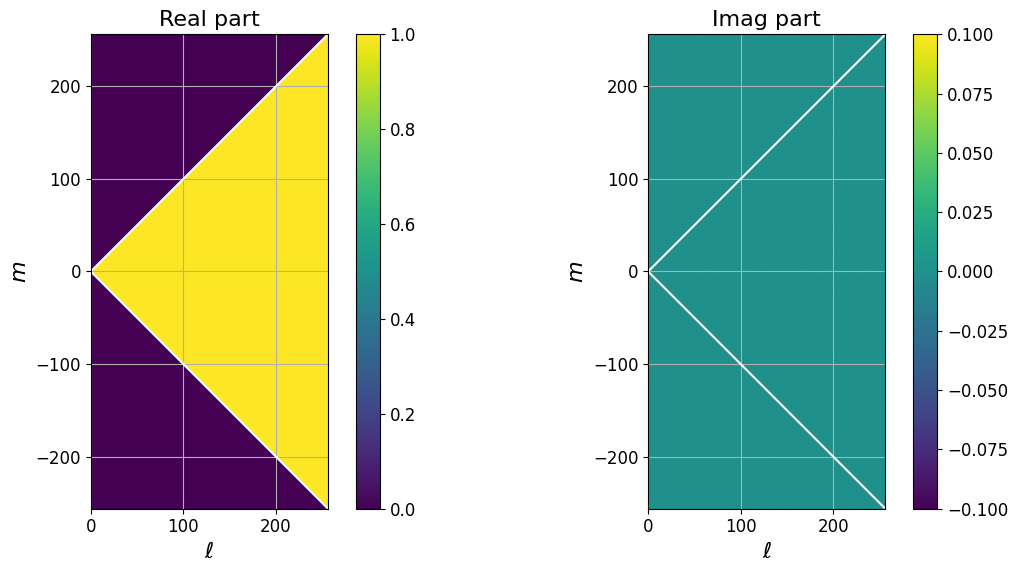

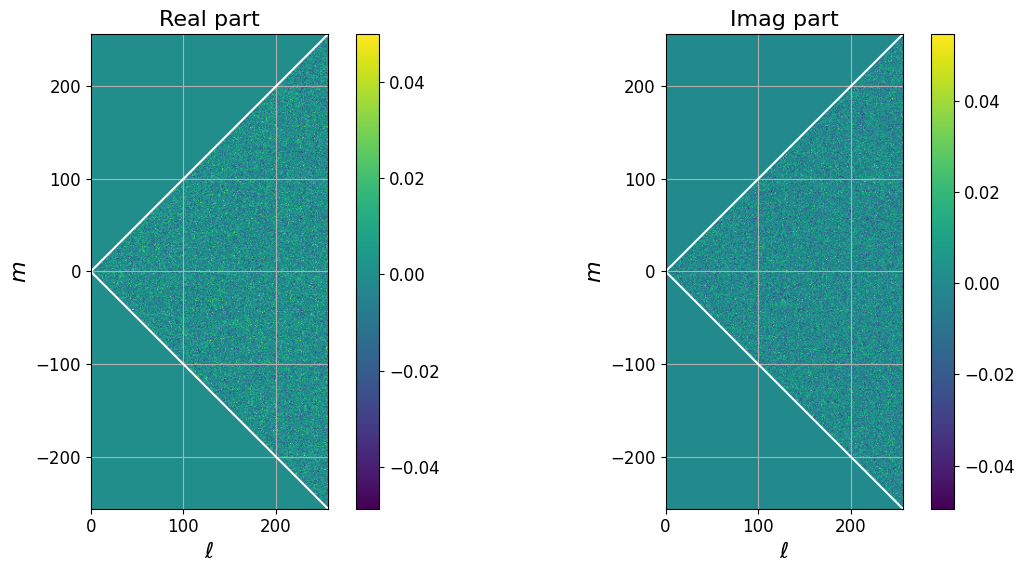

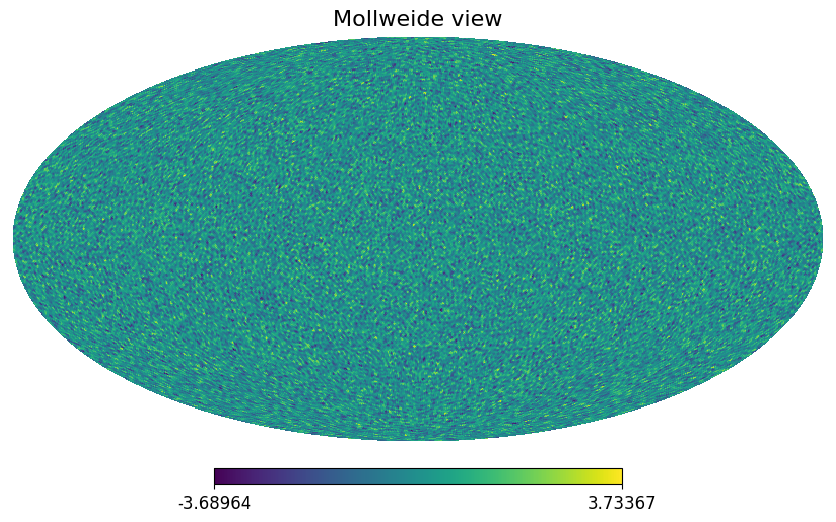

In [132]:
### STD de la carte target Hpx
sigma_target =  np.std(f_target_hpx)
print(sigma_target)

### STD des flm de la target
concat = np.concatenate((np.real(flm_target), np.imag(flm_target)))
sigma_bar = np.std(concat[concat!=0])
print(sigma_bar)

### Make a mask where alm=0 in the 2D array
themask = np.real(np.nan_to_num(flm_target_full/flm_target_full))
fig = plot.plot_alm(themask, reality=False)

### Make white noise alm
flm_imag = np.random.randn(L, 2*L-1) * sigma_bar * themask
flm_real = np.random.randn(L, 2*L-1) * sigma_bar * themask
flm = flm_real + 1j * flm_imag
fig = plot.plot_alm(flm, reality=False)

### Make a healpix map to check it looks like white noise
f = s2fft.inverse_jax(flm, L, nside=nside, sampling='healpix', reality=False)
hp.mollview(f)

### Cut the flm
flm = flm[:, L - 1:] if reality else flm

### Save the start point as we will iterate on flm
flm_start = jnp.copy(flm)  

In [133]:
### Check the STD at map level
print(np.std(f_target_hpx), np.std(f))

### Check the STD at flm level
c = np.real(flm)
d = np.imag(flm)
concat2 = np.concatenate((np.real(flm_target), np.imag(flm_target)))
sigma_bar2 = np.std(concat2[concat2!=0])
print(sigma_bar, sigma_bar2)

1.0982695690751911 1.1763357083351254
0.011534603647103752 0.011534603647103752


## White noise in pixel space

In [ ]:
# Gaussian white noise in pixel space with the variance of the target
print(f'{tvar=}')
np.random.seed(42)

### White noise in MW => Mauvaise idée, le bruit n'est pas homogène sur la sphere
#if reality:  # Real map
 #   f = np.sqrt(tvar) * np.random.randn(L, 2 * L - 1).astype(np.float64)
#else:
 #   f = np.sqrt(tvar) * np.random.randn(L, 2 * L - 1).astype(np.float64) + 1j * np.random.randn(L, 2 * L - 1).astype(np.float64)
#plt.figure()
#plt.imshow(np.real(f), vmax=mx, vmin=mn, cmap='viridis')
#fig = plot.plot_map_MW_Mollweide(f, vmin=mn, vmax=mx, title=f'Start - {mn=:.2f}, {mx=:.2f}', figsize=(10, 6),
 #                        pole_latitude=0, pole_longitude=90)
#flm = s2fft.forward_jax(f, L, reality=reality)


### White noise in Hpx
tvar_hpx = np.var(f_target_hpx)
print(tvar_hpx)
#f = np.sqrt(tvar_hpx) * np.random.randn(12*nside**2)
f = np.random.randn(12*nside**2)
hp.mollview(f, min=-1, max=3, title='f in Healpix')
flm = s2fft.forward_jax(f, L, nside=nside, sampling='healpix', reality=reality)

ps = sphlib.compute_ps(flm, reality=True)

# Cut the flm
flm = flm[:, L - 1:] if reality else flm

# Plot the alm
plot.plot_alm(flm, reality=True)

flm_start = jnp.copy(flm)  # Save the start point as we will iterate on flm

#f_back = s2fft.inverse_jax(flm, L, reality=reality)

#plt.figure()
#plt.imshow(np.real(f_back), vmax=mx, vmin=mn, cmap='viridis')

#fig = plot.plot_map_MW_Mollweide(f_back, vmin=mn, vmax=mx, title=f'Start - {mn=:.2f}, {mx=:.2f}', figsize=(10, 6),
 #                        pole_latitude=0, pole_longitude=90)


# Run the synthesis

## Gradient descent à la main : on veut pas faire ça nous même

- Si je ne mets pas le conjugué, ça diverge.
- Avec le conjugué, ça descend lentement et le PS et la carte ne changent pas bcp

In [28]:
# niter = 400
# momentum = 1
# flm, loss_history = synlib.fit_brutal(flm, loss_func_P00_only, momentum=momentum, niter=niter, loss_history=None)

# flm_end = jnp.copy(flm)

## Using Optax

- Avec Adam, ca converge bien et le PS et la carte ont l'air ok

In [29]:
#niter = 200
#lr = 1e-2
#optimizer = optax.fromage(lr)
#optimizer = optax.adam(lr)
#optimizer = optax.adagrad(lr)
#flm, loss_history = synlib.fit_optax(flm, optimizer, loss_func_P00_only, niter=niter, loss_history=None)

#flm_end = jnp.copy(flm)

## Using Jaxopt

- Methods : GradientDescent ou LBFGS
- Ne marche pas avec des complexes, c'est pour ça que la loss divergeait systématiquement.
- Avec LBFGS, il est bcp + lent que Jaxopt.scipy.minimize('LBFGS')

In [30]:
#flm_float = jnp.array([jnp.real(flm), jnp.imag(flm)])
#flm, loss_history = synlib.fit_jaxopt(flm_float, loss_func, method='GradientDescent', niter=400, loss_history=None)

# flm_end = jnp.copy(flm)
#flm_end = flm[0, :, :] + 1j * flm[1, :, :]

## Using jaxopt Scipy

- Methods: CG, Newton-CG, L-BFGS-B
- Ca ne marche pas avec des complexes. Par défaut, il convertit les arrays en float 64. Résultat on a une carte output symmétrique parce que la partie Im des flm est mise à 0. 
- Si on itère sur les parties Re et Im ça marche. 

In [34]:
### PS only with P00 in pixel space
#flm_float = jnp.array([jnp.real(flm), jnp.imag(flm)])  # [2, L, L]     

#f, loss_history = synlib.fit_jaxopt_Scipy(np.real(f), loss_func_P00pix, method='L-BFGS-B', niter=150, loss_history=None)

#flm_end = jnp.copy(flm)
#flm_end = flm[0, :, :] + 1j * flm[1, :, :]

#flm_end = s2fft.forward_jax(f, L, reality=True)
# Cut the flm
#flm_end = flm_end[:, L - 1:] if reality else flm

In [69]:
### PS only with P00
flm_float = jnp.array([jnp.real(flm), jnp.imag(flm)])  # [2, L, L]     

flm, loss_history = synlib.fit_jaxopt_Scipy(flm_float, loss_func_P00, method='L-BFGS-B', niter=100, loss_history=None)

flm_end = jnp.copy(flm)
flm_end = flm[0, :, :] + 1j * flm[1, :, :]

Iter 0, Success: False, Loss = 3.235531053295452, Time = 4.0837647915 s/iter
Iter 10, Success: False, Loss = 5.966745768620955e-06, Time = 0.0343091488 s/iter
Iter 20, Success: True, Loss = 1.3308857141287198e-11, Time = 0.0313601494 s/iter
Iter 30, Success: True, Loss = 1.3308857141287198e-11, Time = 0.0285420418 s/iter
Iter 40, Success: True, Loss = 1.3308857141287198e-11, Time = 0.0282723904 s/iter
Iter 50, Success: True, Loss = 1.3308857141287198e-11, Time = 0.0285282135 s/iter
Iter 60, Success: True, Loss = 1.3308857141287198e-11, Time = 0.0284643173 s/iter
Iter 70, Success: True, Loss = 1.3308857141287198e-11, Time = 0.0282652378 s/iter
Iter 80, Success: True, Loss = 1.3308857141287198e-11, Time = 0.0285089016 s/iter
Iter 90, Success: True, Loss = 1.3308857141287198e-11, Time = 0.0288014412 s/iter


In [129]:
### PS only with P00'
#flm_float = jnp.array([jnp.real(flm), jnp.imag(flm)])  # [2, L, L]     

#flm, loss_history = synlib.fit_jaxopt_Scipy(flm_float, loss_func_P00prime, method='L-BFGS-B', 
                      #                      niter=400, loss_history=None)

#flm_end = jnp.copy(flm)
#flm_end = flm[0, :, :] + 1j * flm[1, :, :]

In [130]:
### All coeffs
#flm_float = jnp.array([jnp.real(flm), jnp.imag(flm)]) # [2, L, L]          

#flm, loss_history = synlib.fit_jaxopt_Scipy(flm_float, loss_func, method='L-BFGS-B', niter=400, loss_history=None)

#flm_end = jnp.copy(flm)
#flm_end = flm[0, :, :] + 1j * flm[1, :, :]

In [131]:
### P00' and then all coeffs
#flm_float = jnp.array([jnp.real(flm), jnp.imag(flm)]) # [2, L, L]          

#flm, loss_historyPS = synlib.fit_jaxopt_Scipy(flm_float, loss_func_P00prime, method='L-BFGS-B', niter=100, loss_history=None)

#flm, loss_history = synlib.fit_jaxopt_Scipy(flm, loss_func, method='L-BFGS-B', niter=300, loss_history=loss_historyPS)

#flm_end = jnp.copy(flm)
#flm_end = flm[0, :, :] + 1j * flm[1, :, :]


In [132]:
#flm_start = jnp.copy(flm_end) 
#flm = jnp.copy(flm_end) 

In [134]:
### All at the same time: P00' and all coeffs in the same loss
flm_float = jnp.array([jnp.real(flm), jnp.imag(flm)]) # [2, L, L]          

niter=100
flm, loss_history = synlib.fit_jaxopt_Scipy(flm_float, loss_func_all, method='L-BFGS-B', niter=niter, 
                                            loss_history=None)

#flm_end = jnp.copy(flm)
flm_end = flm[0, :, :] + 1j * flm[1, :, :]

Iter 0, Success: False, Loss = 145.35203210690167, Time = 93.8602015972 s/iter
Iter 10, Success: False, Loss = 10.50140055011359, Time = 0.3488051891 s/iter
Iter 20, Success: False, Loss = 5.6286588921844505, Time = 0.3592519760 s/iter
Iter 30, Success: False, Loss = 3.0875826596554554, Time = 0.3508651257 s/iter
Iter 40, Success: False, Loss = 2.651391463723007, Time = 0.3487775326 s/iter
Iter 50, Success: False, Loss = 2.203084159959279, Time = 1.1911053658 s/iter
Iter 60, Success: False, Loss = 1.8759412283957733, Time = 1.1759481430 s/iter
Iter 70, Success: False, Loss = 1.7982274787144, Time = 0.3530092239 s/iter
Iter 80, Success: False, Loss = 1.7285906590123736, Time = 0.3566172123 s/iter
Iter 90, Success: False, Loss = 1.2216178550970993, Time = 0.3707976341 s/iter


# Check the synthesis

In [135]:
### Coeffs
# Start
scoeffs = scatlib.scat_cov_dir(flm_start, L, N, J_min, lam, sampling, None,
                           reality, multiresolution, for_synthesis=True, normalisation=tP00_norm,
                           filters=filters, quads=weights, precomps=precomps)
# End
ecoeffs = scatlib.scat_cov_dir(flm_end, L, N, J_min, lam, sampling, None,
                       reality, multiresolution, for_synthesis=True, normalisation=tP00_norm,
                       filters=filters, quads=weights, precomps=precomps)

# Gaussian
all_gcoeffs = []
for n in range(ngauss):
    all_gcoeffs.append(scatlib.scat_cov_dir(np.nan_to_num(flm_gauss[n]), L, N, J_min, lam, sampling, None,
                       reality, multiresolution, for_synthesis=True, normalisation=tP00_norm,
                       filters=filters, quads=weights, precomps=precomps))


tmean, tvar, tS1, tP00, tC01, tC11 = tcoeffs
smean, svar, sS1, sP00, sC01, sC11 = scoeffs
emean, evar, eS1, eP00, eC01, eC11 = ecoeffs

In [136]:
print(flm_target.shape, flm_start.shape, flm_end.shape)

(256, 256) (256, 256) (256, 256)


## Cut the flm that are not contrained

In [137]:
### Cut the flm that are not contrained
flm_target = flm_target.at[0: int(lam**J_min) + 1, :].set(0. + 0.j)
flm_end = flm_end.at[0: int(lam**J_min) + 1, :].set(0. + 0.j)
flm_start = flm_start.at[0: int(lam**J_min) + 1, :].set(0. + 0.j)
for n in range(ngauss):
    flm_gauss[n][0: int(lam**J_min) + 1, :] = 0. + 0.j

In [138]:
flm_gauss.shape

(10, 256, 256)

In [139]:
# Make the maps
f_target = s2fft.inverse_jax(flm_target, L, reality=reality)
f_start = s2fft.inverse_jax(flm_start, L, reality=reality)
f_end = s2fft.inverse_jax(flm_end, L, reality=reality)

allf_gauss = np.zeros((ngauss, L, 2*L-1))
for n in range(ngauss):
    allf_gauss[n] = s2fft.inverse_jax(flm_gauss[n], L, reality=reality)

## Mean and var

In [140]:
print('Mean:', tmean, smean, emean)
print('Var:', tvar, svar, evar)

Mean: 0.10742234501762578 0.0035194102916656553 0.015559692768114248
Var: (1.2061931074241314+0j) (1.3837492961951154+0j) (1.0864270435107506+0j)


## Plot the loss

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


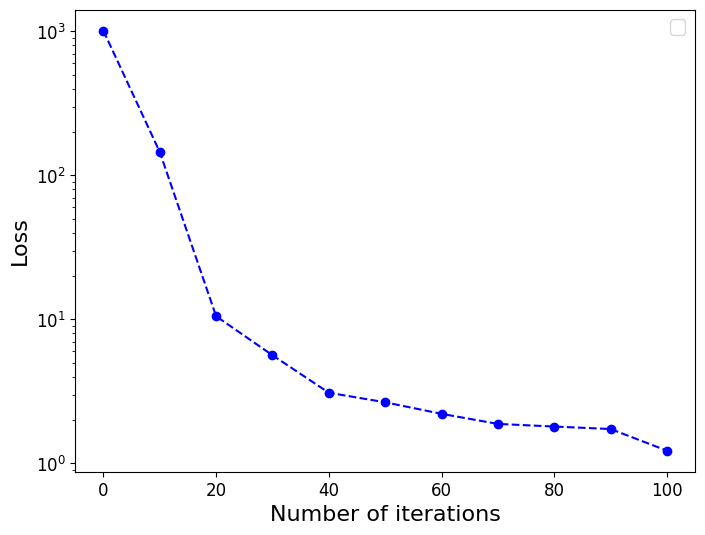

In [141]:
nit1 = 100#niter
nit2 = 0
step = 10

plt.figure(figsize=(8, 6))
plt.plot(np.arange(0, nit1+1, step), loss_history[:int(nit1/step)+1], 'bo--', label="")
#plt.plot(np.arange(nit1, nit1 + nit2, step), loss_history[int(nit1/step)+1:], 'ro--', label='All coeffs')
#plt.plot(np.arange(nit1, nit1 + nit2 + 1, step), loss_history, 'ro--', label='All coeffs')

plt.yscale('log')
plt.ylabel('Loss')
plt.xlabel('Number of iterations')
plt.legend()

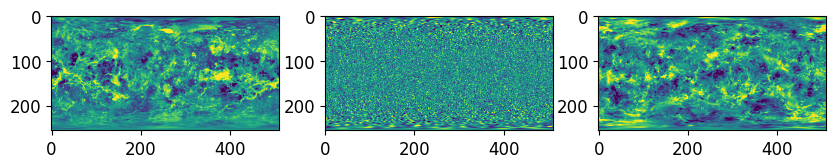

In [142]:
#mn, mx = np.nanmin(f_target), np.nanmax(f_target)
#mn, mx = -1, 3
#mn, mx = None, None
mn, mx = -2, 2


fig, (ax1,ax2, ax3) = plt.subplots(1,3, figsize=(10,3))
ax1.imshow(np.real(f_target), vmax=mx, vmin=mn, cmap='viridis')
ax2.imshow(np.real(f_start), vmax=mx, vmin=mn, cmap='viridis')
ax3.imshow(f_end, vmax=mx, vmin=mn, cmap='viridis')
plt.show()

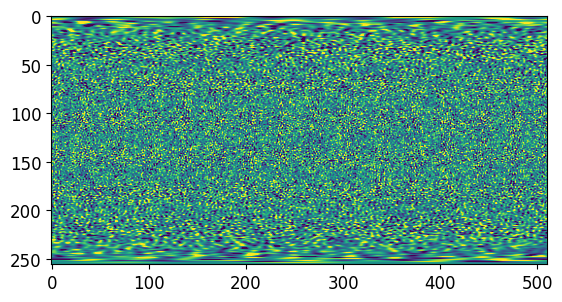

In [143]:
plt.figure()
plt.imshow(f_start, vmax=mx, vmin=mn, cmap='viridis')

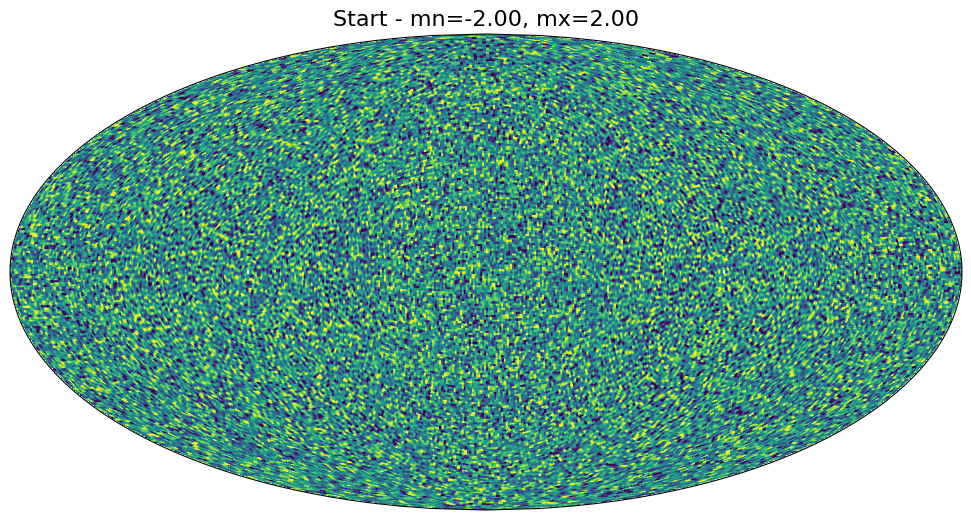

In [144]:
reload(plot)
fig = plot.plot_map_MW_Mollweide(f_start, vmin=mn, vmax=mx, title=f'Start - {mn=:.2f}, {mx=:.2f}', figsize=(10, 6),
                          pole_latitude=0, pole_longitude=90)

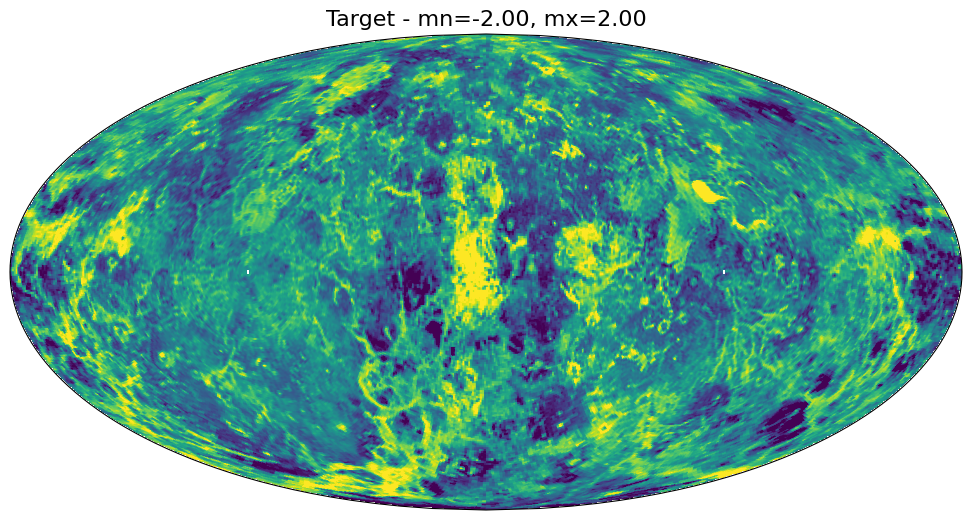

In [145]:
reload(plot)
fig = plot.plot_map_MW_Mollweide(f_target, vmin=mn, vmax=mx, title=f'Target - {mn=:.2f}, {mx=:.2f}', figsize=(10, 6),
                          pole_latitude=0, pole_longitude=90)

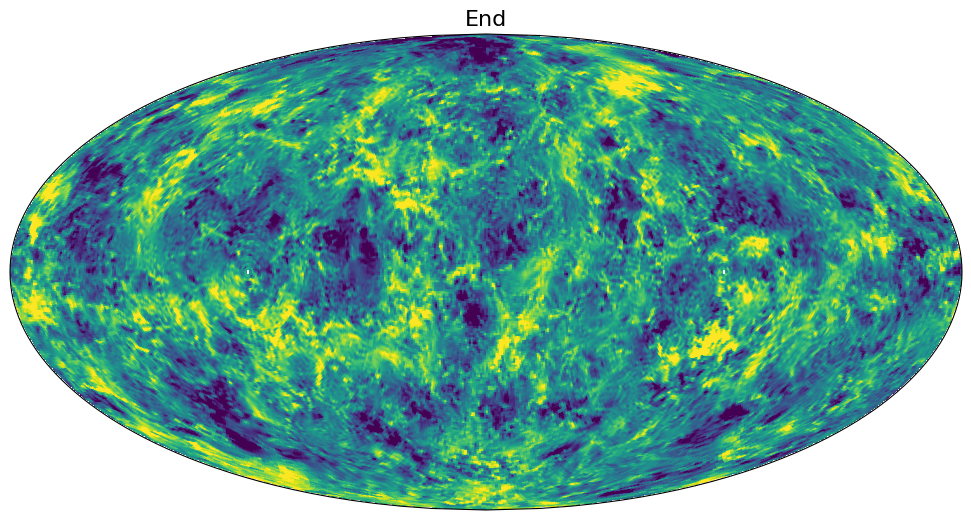

In [146]:
fig = plot.plot_map_MW_Mollweide(f_end, vmin=-2, vmax=2, figsize=(10, 6), 
                           pole_latitude=0, pole_longitude=90, title=f'End')

In [63]:
reload(plot)
import scipy as sc

from scipy.ndimage.filters import generic_filter

stdi = generic_filter(f_start, np.var, size=20)
fig = plot.plot_map_MW_Mollweide(stdi, vmin=0, vmax=1.5, figsize=(10, 6), 
                                pole_latitude=lat, pole_longitude=lon, title=f'Start - Local variance - {lat=} - {lon=}',
                                colorbar=True)

NameError: name 'lat' is not defined

In [ ]:
#np.save(f'./f_end_{niter}', f_end)

In [64]:
# Make a Gif
#for niter in [1, 2, 3, 10, 40, 60, 100, 150]:
  #  toto1 = np.load(f'./f_end_{niter}.npy')
  #  toto2 = np.load(f'./f_end_{niter-1}.npy')
  #  lat, lon = 0, 90
  #  diff = toto1-toto2
  #  std = np.std(diff)
  #  fig = plot.plot_map_MW_Mollweide(toto1-toto2, vmin=-3*std, vmax=3*std, figsize=(10, 6), 
  #                        pole_latitude=lat, pole_longitude=lon, title=f'Diff {niter} - {niter-1}, {lat=} - {lon=}')
  #  fig.savefig(f'f_diff_{niter:03}.png')

In [62]:
#import glob
#from PIL import Image
#def make_gif(frame_folder):
#    frames = []
#    for niter in [1, 2, 3, 10, 40, 60, 100, 150]:
#        image = glob.glob(f"{frame_folder}/*diff*{niter:03}.png")[0]
#        frames.append(Image.open(image))
#    #frames = [Image.open(image) for image in glob.glob(f"{frame_folder}/*.png")]
#    frame_one = frames[0]
#    frame_one.save("gif_diff_LSS.gif", format="GIF", append_images=frames,
#               save_all=True, duration=1500, loop=0)
#    return

#make_gif('./')

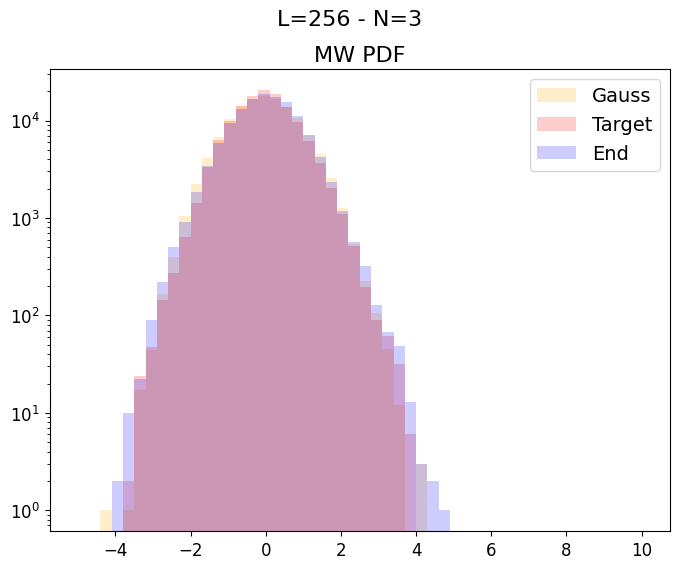

In [63]:
fig, (ax1) = plt.subplots(1, 1, figsize=(8, 6))
fig.suptitle(f'{L=} - {N=}')
#histrange = (f_end.min(), f_end.max())
histrange = (-5, 10)
ax1.hist(np.ravel(allf_gauss[0]), bins=50,  range=histrange, 
         density=False, color='orange', alpha=0.2, label='Gauss')
ax1.hist(np.ravel(f_target), bins=50,  range=histrange, 
         density=False, color='r', alpha=0.2, label='Target')
ax1.hist(np.ravel(f_end), bins=50,  range=histrange, 
         density=False, color='b', alpha=0.2, label='End')
#ax1.hist(np.ravel(f_start), bins=30, density=True, color='g', alpha=0.2, label='Start')
ax1.set_title('MW PDF')
ax1.set_yscale("log")
#ax1.set_ylim(10, 1e5)
ax1.legend()

## Power spectrum

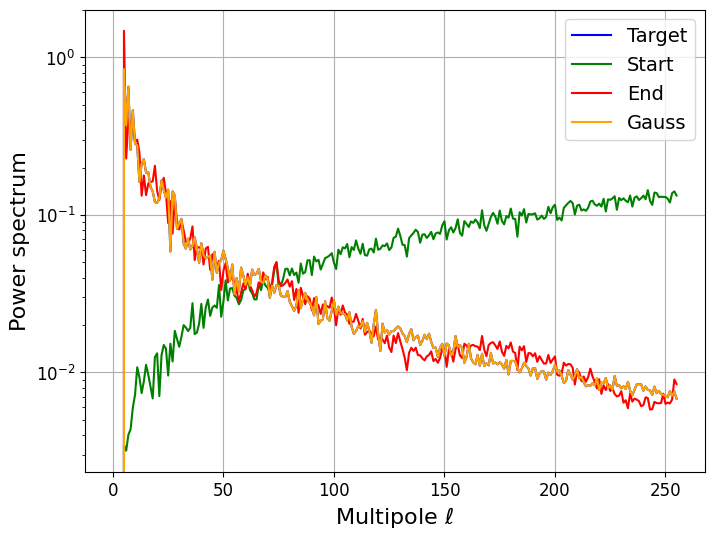

In [147]:
ps_target = sphlib.compute_ps(flm_target, reality=True)
ps_start = sphlib.compute_ps(flm_start, reality=True)
ps_end = sphlib.compute_ps(flm_end, reality=True)

n = 0
ps_gauss = sphlib.compute_ps(flm_gauss[n], reality=True)

plt.figure(figsize=(8, 6))
plt.plot(ps_target, 'b', label="Target")
plt.plot(ps_start, 'g', label="Start")
plt.plot(ps_end, 'r', label="End")
plt.plot(ps_gauss, 'orange', label="Gauss")
plt.yscale("log")
#plt.xscale("log", base=2)
plt.xlabel(r'Multipole $\ell$')
plt.ylabel('Power spectrum')
plt.grid()
#plt.xlim(2, 64)
#plt.ylim(1e-4, 1)
plt.legend()

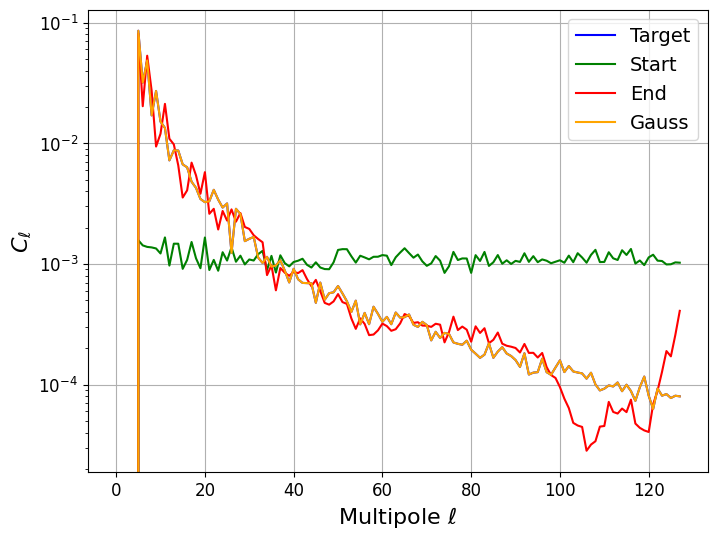

In [66]:
ell = np.arange(L)

plt.figure(figsize=(8, 6))
plt.plot(ell, ps_target/(2*ell+1), 'b', label="Target")
plt.plot(ell, ps_start/(2*ell+1), 'g', label="Start")
plt.plot(ell, ps_end/(2*ell+1), 'r', label="End")
plt.plot(ell, ps_gauss/(2*ell+1), 'orange', label="Gauss")
plt.yscale("log")
#plt.xscale("log", base=2)
plt.xlabel(r'Multipole $\ell$')
plt.ylabel(r'$C_{\ell}$')
plt.grid()
#plt.xlim(2, 64)
#plt.ylim(1e-4, 1)
plt.legend()

## Plot the coefficients

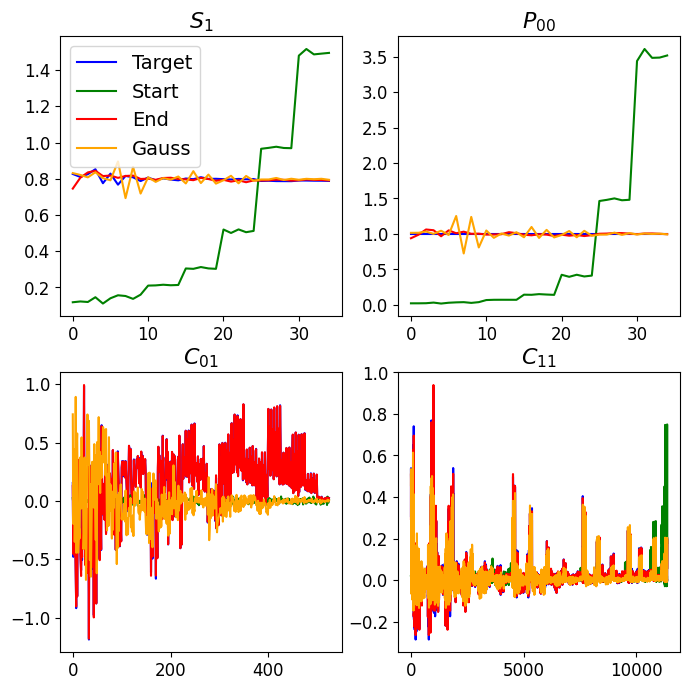

In [82]:
n=0
gmean, gvar, gS1, gP00, gC01, gC11 = all_gcoeffs[n]

plot.plot_scatcov_coeffs(tS1, tP00, tC01, tC11, name='Target', hold=True, color='blue')

plot.plot_scatcov_coeffs(sS1, sP00, sC01, sC11, name='Start', hold=False, color='green')

plot.plot_scatcov_coeffs(eS1, eP00, eC01, eC11, name='End', hold=False, color='red')

plot.plot_scatcov_coeffs(gS1, gP00, gC01, gC11, name='Gauss', hold=False, color='orange')

## Minkowski

In [68]:
### Convert the map in a Healpix map
f_target_hpx = s2fft.inverse_jax(flm_target, L, nside=int(L/2), reality=reality, sampling='healpix')
f_start_hpx = s2fft.inverse_jax(flm_start, L, nside=int(L/2), reality=reality, sampling='healpix')
f_end_hpx = s2fft.inverse_jax(flm_end, L, nside=int(L/2), reality=reality, sampling='healpix')

# Take the real part and convert to a np.array
f_target_hpx = np.array(np.real(f_target_hpx))
f_start_hpx = np.array(np.real(f_start_hpx))
f_end_hpx = np.array(np.real(f_end_hpx))

In [69]:
f_target_exp = np.exp(f_target_hpx + 2) - 1e-4
f_start_exp = np.exp(f_start_hpx + 2) - 1e-4
f_end_exp = np.exp(f_end_hpx + 2) - 1e-4

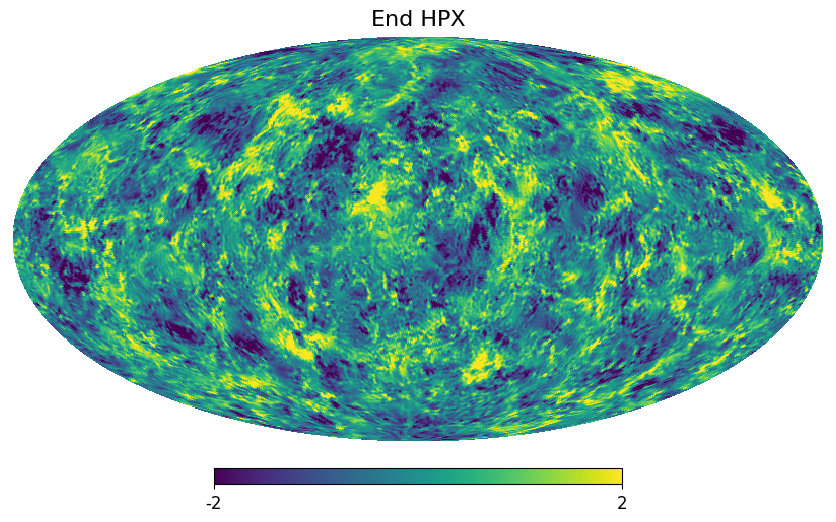

In [70]:
import healpy as hp
hp.mollview(f_end_hpx, min=mn, max=mx, title='End HPX', rot=(0, lon, lat))

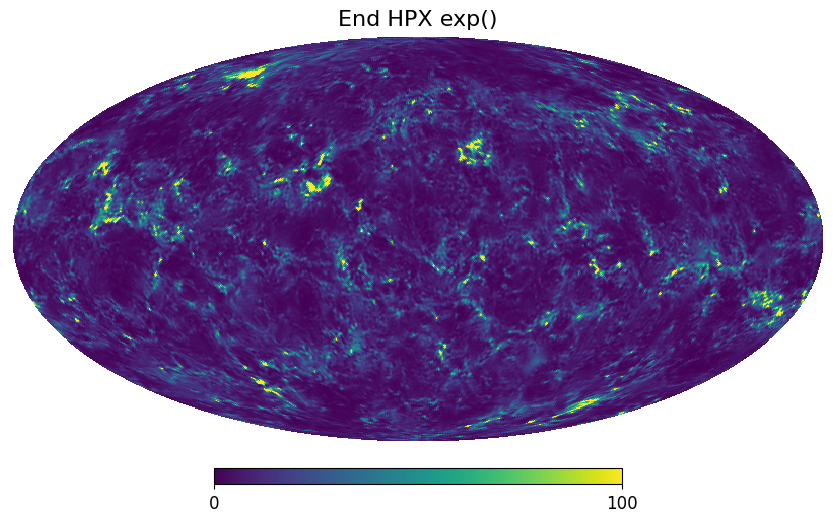

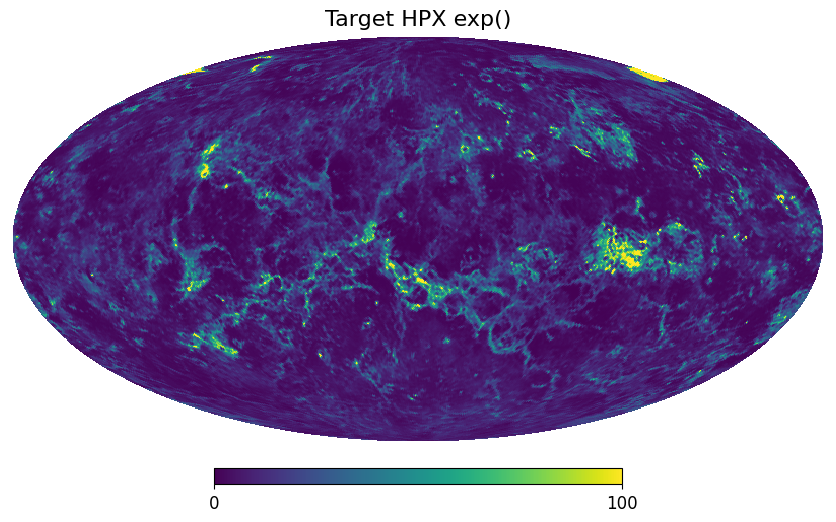

In [71]:
import healpy as hp
hp.mollview(f_end_exp, min=0, max=100, title='End HPX exp()')
hp.mollview(f_target_exp, min=0, max=100, title='Target HPX exp()')

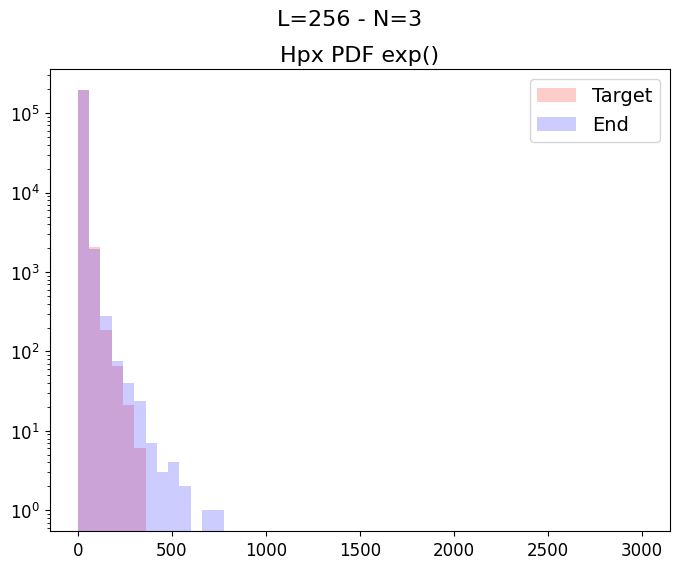

In [72]:
fig, (ax1) = plt.subplots(1, 1, figsize=(8, 6))
fig.suptitle(f'{L=} - {N=}')
#histrange = (f_end.min(), f_end.max())
histrange = (0, 3000)
ax1.hist(np.ravel(f_target_exp), bins=50,  range=histrange, 
         density=False, color='r', alpha=0.2, label='Target')
ax1.hist(np.ravel(f_end_exp), bins=50,  range=histrange, 
         density=False, color='b', alpha=0.2, label='End')
#ax1.hist(np.ravel(f_start), bins=30, density=True, color='g', alpha=0.2, label='Start')
ax1.set_title('Hpx PDF exp()')
ax1.set_yscale("log")
#ax1.set_ylim(10, 1e5)
ax1.legend()

In [73]:
import pynkowski as mf
def make_minkowski(us, map_hpx):

    data = mf.Healpix(map_hpx, normalise=True, mask=None)     # Default parameters
    v0 = mf.V0(data, us)
    v1 = mf.V1(data, us)
    v2 = mf.V2(data, us)
    
    return v0, v1, v2

In [74]:
us = np.arange(-5., 7.01, 0.1)

v0_target, v1_target, v2_target = make_minkowski(us, f_target_hpx)
v0_start, v1_start, v2_start = make_minkowski(us, f_start_hpx)
v0_end, v1_end, v2_end = make_minkowski(us, f_end_hpx)

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

In [75]:
# Gaussian real
all_v0_gauss, all_v1_gauss, all_v2_gauss  = np.zeros((ngauss, v0_target.size)), np.zeros((ngauss, v0_target.size)), np.zeros((ngauss, v0_target.size))
for n in range(ngauss):
    all_v0_gauss[n], all_v1_gauss[n], all_v2_gauss[n] = make_minkowski(us, f_gauss_hpx[n, :])
    
# Average and std over Gaussian realisations 
mean_v0_gauss = np.mean(all_v0_gauss, axis=0)
mean_v1_gauss = np.mean(all_v1_gauss, axis=0)
mean_v2_gauss = np.mean(all_v2_gauss, axis=0)

std_v0_gauss = np.std(all_v0_gauss, axis=0)
std_v1_gauss = np.std(all_v1_gauss, axis=0)
std_v2_gauss = np.std(all_v2_gauss, axis=0)

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

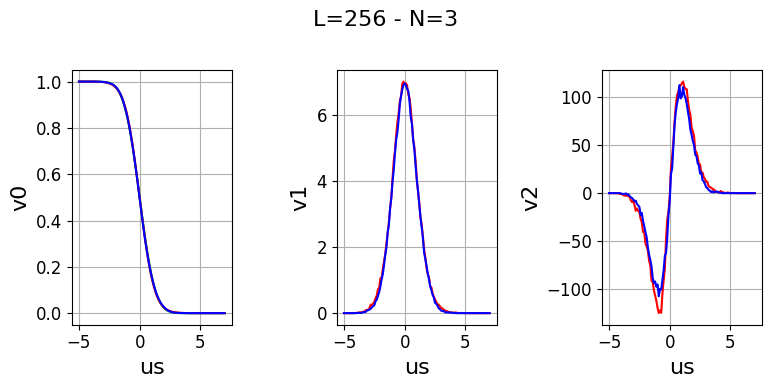

In [76]:
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(8, 4))
fig.suptitle(f'{L=} - {N=}')

ax0.plot(us, v0_start, color='g', label='Start')
ax0.plot(us, v0_end, color='r', label='End')
ax0.plot(us, v0_target, color='b', label='Target')
ax0.set_xlabel('us')
ax0.set_ylabel('v0')
ax0.grid()
#ax0.legend()

#ax1.plot(us, v1_start, color='g', label='Start')
ax1.plot(us, v1_end, color='r', label='End')
ax1.plot(us, v1_target, color='b', label='Target')
ax1.set_xlabel('us')
ax1.set_ylabel('v1')
ax1.grid()
#ax1.legend()

#ax2.plot(us, v2_start, color='g', label='Start')
ax2.plot(us, v2_end, color='r', label='End')
ax2.plot(us, v2_target, color='b', label='Target')
ax2.set_xlabel('us')
ax2.set_ylabel('v2')
ax2.grid()
#ax2.legend()

fig.tight_layout()

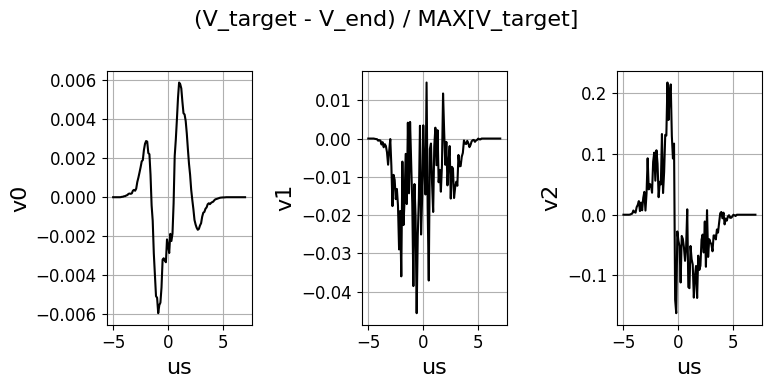

In [77]:
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(8, 4))
fig.suptitle(f'(V_target - V_end) / MAX[V_target]')

ax0.plot(us, (v0_target - v0_end)/np.max(v0_target), color='k')
ax0.set_xlabel('us')
ax0.set_ylabel('v0')
ax0.grid()

ax1.plot(us, (v1_target - v1_end)/np.max(v1_target), color='k')
ax1.set_xlabel('us')
ax1.set_ylabel('v1')
ax1.grid()

ax2.plot(us, (v2_target - v2_end)/np.max(v2_target), color='k')
ax2.set_xlabel('us')
ax2.set_ylabel('v2')
ax2.grid()

fig.tight_layout()

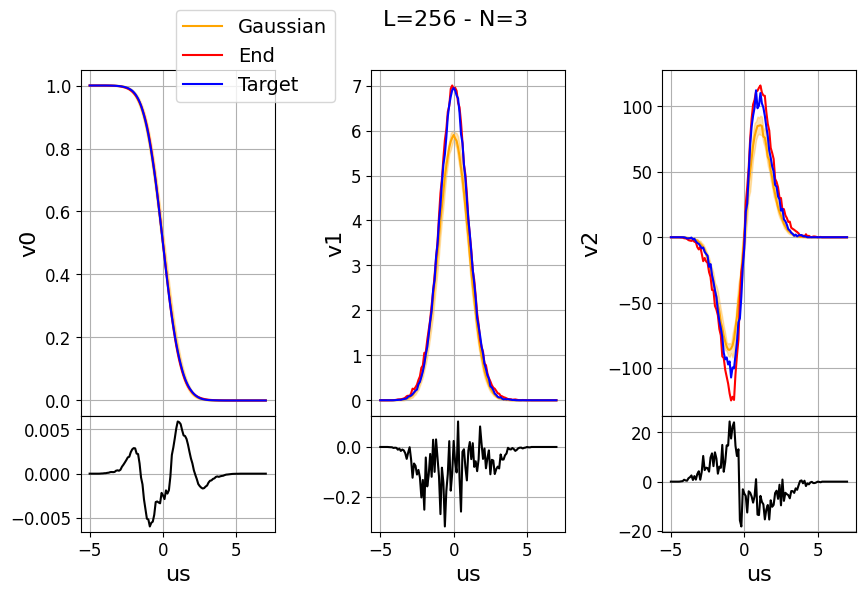

In [78]:
fig, axs = plt.subplots(2, 3, sharex='col', figsize=(10, 6), gridspec_kw={'height_ratios': [3, 1]})
axs = axs.ravel()
(ax0, ax1, ax2, ax3, ax4, ax5) = axs
fig.subplots_adjust(hspace=0, wspace=0.5)

fig.suptitle(f'{L=} - {N=}')
ns = 1
#ax0.plot(us, v0_start, color='g', label='Start')
ax0.plot(us, mean_v0_gauss, color='orange', label='Gaussian')
ax0.fill_between(us, mean_v0_gauss - ns*std_v0_gauss, mean_v0_gauss + ns*std_v0_gauss, color='orange', alpha=0.3)
ax0.plot(us, v0_end, color='r', label=f'End')
ax0.plot(us, v0_target, color='b', label='Target')
ax0.set_ylabel('v0')
ax0.grid()
ax0.legend(loc='upper center', bbox_to_anchor=(0.9, 1.2), ncol=1, fontsize=14)

#ax1.plot(us, v1_start, color='g', label='Start')
ax1.plot(us, mean_v1_gauss, color='orange', label='Gaussian')
ax1.fill_between(us, mean_v1_gauss - ns*std_v1_gauss, mean_v1_gauss + ns*std_v1_gauss, color='orange', alpha=0.3)
ax1.plot(us, v1_end, color='r', label='End')
ax1.plot(us, v1_target, color='b', label='Target')
ax1.set_ylabel('v1')
ax1.grid()

#ax2.plot(us, v2_start, color='g', label='Start')
ax2.plot(us, mean_v2_gauss, color='orange', label='Gaussian')
ax2.fill_between(us, mean_v2_gauss - ns*std_v2_gauss, mean_v2_gauss + ns*std_v2_gauss, color='orange', alpha=0.3)
ax2.plot(us, v2_end, color='r', label='End')
ax2.plot(us, v2_target, color='b', label='Target')
ax2.set_ylabel('v2')
ax2.grid()
#ax2.legend()

ax3.plot(us, (v0_target - v0_end), color='k')
ax3.set_xlabel('us')
ax3.grid()

ax4.plot(us, (v1_target - v1_end), color='k')
ax4.set_xlabel('us')
ax4.grid()

ax5.plot(us, (v2_target - v2_end), color='k')
ax5.set_xlabel('us')
ax5.grid()
